# GPR Signal Processing & Exhibit 1 Generation
**Objective:** This notebook validates the GPR spike detection algorithm and generates the primary macro exhibit for the CFA publication.

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# --- Setup Paths and Imports ---
# Robustly add the parent 'src' directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

plt.style.use('ggplot')

from gpr_overlay.services.gpr_ingestion_service import load_gpr_daily_from_csv
from gpr_overlay.services.gpr_event_detection_service import detect_gpr_events

# --- Load Data and Run Detection ---
gpr_path = os.path.join(project_root, 'data', 'gpr_daily_sample.csv')

# Load raw series (service returns Pydantic models)
points = load_gpr_daily_from_csv(gpr_path)

# Convert to DataFrame for plotting
records = [{'date': pd.to_datetime(p.date), 'gprd': float(p.gprd)} for p in points]
df = pd.DataFrame.from_records(records).sort_values('date').reset_index(drop=True)

# Detect events using the project's spike-only detection routine
events = detect_gpr_events(points, include_regimes=False)

print(f"Data loaded. Found {len(events)} spike events in the full history.")

Data loaded. Found 575 spike events in the full history.


## Plot 1.1: Full History Audit
This plot validates the spike detector across the entire GPR history, ensuring it correctly identifies major historical events without clutter. This plot is for internal validation and will remain in the notebook.

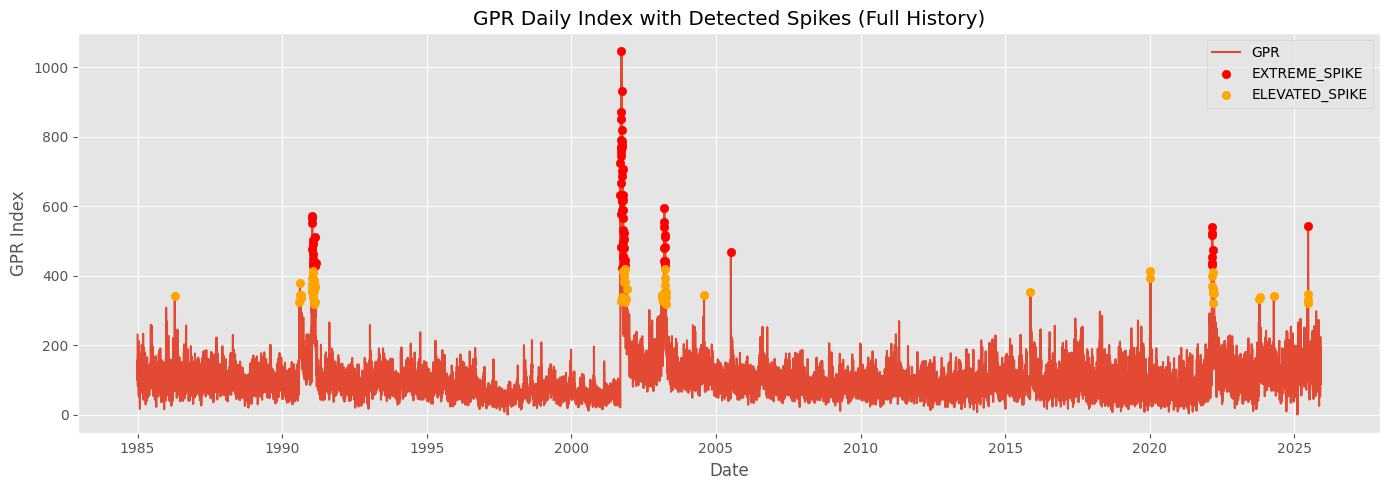

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(df['date'], df['gprd'], label='GPR')
# Collect event markers
ext_dates = []
ext_vals = []
elev_dates = []
elev_vals = []
for e in events:
    # robustly get event type and peak_date
    try:
        et = getattr(e, 'event_type', None)
        et_name = et.name if hasattr(et, 'name') else str(et)
    except Exception:
        et_name = None
    try:
        pd_date = pd.to_datetime(getattr(e, 'peak_date', None))
    except Exception:
        continue
    row = df[df['date'].dt.date == pd_date.date()]
    if row.empty:
        continue
    val = float(row.iloc[0]['gprd'])
    if et_name == 'EXTREME_SPIKE':
        ext_dates.append(pd_date)
        ext_vals.append(val)
    elif et_name == 'ELEVATED_SPIKE':
        elev_dates.append(pd_date)
        elev_vals.append(val)
# Plot markers
ax.scatter(ext_dates, ext_vals, color='red', label='EXTREME_SPIKE', zorder=5)
ax.scatter(elev_dates, elev_vals, color='orange', label='ELEVATED_SPIKE', zorder=5)
ax.set_title('GPR Daily Index with Detected Spikes (Full History)')
ax.set_xlabel('Date')
ax.set_ylabel('GPR Index')
ax.legend()
fig.tight_layout()
plt.show()

## Plot 1.2: Exhibit 1 - The June 2025 GPR Spike
This is the primary, publication-ready exhibit. It focuses on the specific event driving our analysis.

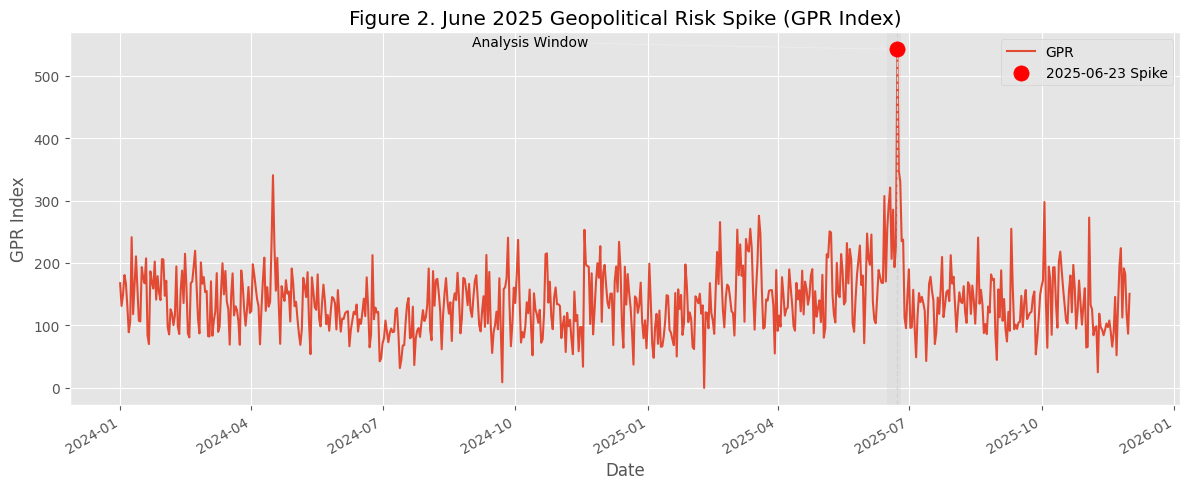

In [4]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12,5))
# focus window
start = pd.to_datetime('2024-01-01')
end = pd.to_datetime('2025-12-31')
window = df[(df['date'] >= start) & (df['date'] <= end)].copy()
ax.plot(window['date'], window['gprd'], label='GPR')
# target event
target = pd.to_datetime('2025-06-23')
row = df[df['date'].dt.date == target.date()]
target_val = None
if not row.empty:
    target_val = float(row.iloc[0]['gprd'])
    ax.scatter([target], [target_val], color='red', s=120, zorder=6, label='2025-06-23 Spike')
# vertical line and shaded analysis window
ax.axvline(target, color='lightgray', linestyle='--', linewidth=1)
ax.axvspan(pd.to_datetime('2025-06-16'), pd.to_datetime('2025-06-25'), color='lightgray', alpha=0.3)
# annotate if we have a value to anchor the annotation
if target_val is not None:
    ax.annotate('Analysis Window', xy=(pd.to_datetime('2025-06-18'), target_val), xytext=(pd.to_datetime('2024-09-01'), target_val+5), arrowprops=dict(arrowstyle='->'))
ax.set_title('Figure 2. June 2025 Geopolitical Risk Spike (GPR Index)')
ax.set_xlabel('Date')
ax.set_ylabel('GPR Index')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

## Plot 1.3: Methodological Appendix - GPR Distribution
This plot provides transparency on how the detection thresholds are set relative to the historical data distribution.

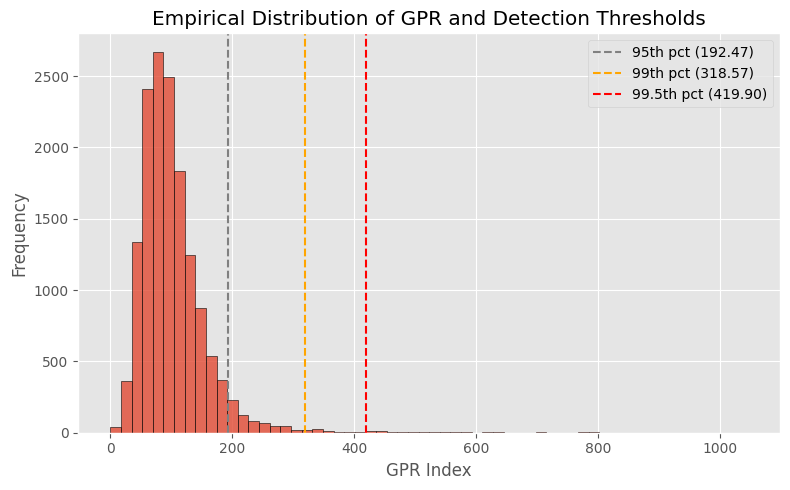

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
vals = df['gprd'].dropna().values
ax.hist(vals, bins=60, color='C0', alpha=0.8, edgecolor='black')
p95 = np.percentile(vals, 95)
p99 = np.percentile(vals, 99)
p995 = np.percentile(vals, 99.5)
ax.axvline(p95, color='gray', linestyle='--', label=f'95th pct ({p95:.2f})')
ax.axvline(p99, color='orange', linestyle='--', label=f'99th pct ({p99:.2f})')
ax.axvline(p995, color='red', linestyle='--', label=f'99.5th pct ({p995:.2f})')
ax.set_title('Empirical Distribution of GPR and Detection Thresholds')
ax.set_xlabel('GPR Index')
ax.set_ylabel('Frequency')
ax.legend()
fig.tight_layout()
plt.show()